<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Retrieval Relevance Evals</h1>

Arize provides tooling to evaluate LLM applications, including tools to determine the relevance or irrelevance of documents retrieved by retrieval-augmented generation (RAG) applications. This relevance is then used to measure the quality of each retrieval using ranking metrics such as precision@k. In order to determine whether each retrieved document is relevant or irrelevant to the corresponding query, our approach is straightforward: ask an LLM.

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to relevance classification against information retrieval datasets with ground-truth relevance labels,
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [2]:
!pip install -qq "arize-phoenix[experimental]" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken

In [3]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import pandas as pd
from phoenix.experimental.evals import (
    RAG_RELEVANCY_PROMPT_RAILS_MAP,
    RAG_RELEVANCY_PROMPT_TEMPLATE_STR,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include:

- "wiki_qa-train"
- "ms_marco-v1.1-train"

In [4]:
df = download_benchmark_dataset(
    task="binary-relevance-classification", dataset_name="wiki_qa-train"
)
df.head()

,query_id,query_text,document_title,document_text,document_text_with_emphasis,relevant
0,Q1,how are glacier caves formed?,Glacier cave,"A partly submerged glacier cave on Perito Moreno Glacier . The ice facade is approximately 60 m high Ice formations in the Titlis glacier cave A glacier cave is a cave formed within the ice of a glacier . Glacier caves are often called ice caves , but this term is properly used to describe bedrock caves that contain year-round ice.","A partly submerged glacier cave on Perito Moreno Glacier . The ice facade is approximately 60 m high Ice formations in the Titlis glacier cave A GLACIER CAVE IS A CAVE FORMED WITHIN THE ICE OF A GLACIER . Glacier caves are often called ice caves , but this term is properly used to describe bedrock caves that contain year-round ice.",True
1,Q10,how an outdoor wood boiler works,Outdoor wood-fired boiler,The outdoor wood boiler is a variant of the classic wood stove adapted for set-up outdoors while still transferring the heat to interior buildings.,The outdoor wood boiler is a variant of the classic wood stove adapted for set-up outdoors while still transferring the heat to interior buildings.,False
2,Q100,what happens to the light independent reactions of photosynthesis?,Light-independent reactions,"The simplified internal structure of a chloroplast Overview of the Calvin cycle and carbon fixation The light-independent reactions of photosynthesis are chemical reactions that convert carbon dioxide and other compounds into glucose . These reactions occur in the stroma , the fluid-filled area of a chloroplast outside of the thylakoid membranes. These reactions take the light-dependent reactions and perform further chemical processes on them. There are three phases to the light-independent reactions, collectively called the Calvin cycle : carbon fixation, reduction reactions, and ribulose 1,5-bisphosphate (RuBP) regeneration. Despite its name, this process occurs only when light is available. Plants do not carry out the Calvin cycle by night. They, instead, release sucrose into the phloem from their starch reserves. This process happens when light is available independent of the kind of photosynthesis ( C3 carbon fixation , C4 carbon fixation , and Crassulacean Acid Metabolism ); CAM plants store malic acid in their vacuoles every night and release it by day in order to make this process work.","The simplified internal structure of a chloroplast Overview of the Calvin cycle and carbon fixation THE LIGHT-INDEPENDENT REACTIONS OF PHOTOSYNTHESIS ARE CHEMICAL REACTIONS THAT CONVERT CARBON DIOXIDE AND OTHER COMPOUNDS INTO GLUCOSE . These reactions occur in the stroma , the fluid-filled area of a chloroplast outside of the thylakoid membranes. THESE REACTIONS TAKE THE LIGHT-DEPENDENT REACTIONS AND PERFORM FURTHER CHEMICAL PROCESSES ON THEM. There are three phases to the light-independent reactions, collectively called the Calvin cycle : carbon fixation, reduction reactions, and ribulose 1,5-bisphosphate (RuBP) regeneration. Despite its name, this process occurs only when light is available. Plants do not carry out the Calvin cycle by night. They, instead, release sucrose into the phloem from their starch reserves. This process happens when light is available independent of the kind of photosynthesis ( C3 carbon fixation , C4 carbon fixation , and Crassulacean Acid Metabolism ); CAM plants store malic acid in their vacuoles every night and release it by day in order to make this process work.",True
3,Q1000,where in the bible that palestine have no land in jerusalem,Philistines,"The Philistine cities of Gaza, Ashdod, Ashkelon, Ekron, and Gath The Philistines (, , , or ; , Plištim), Pleshet or Peleset, were a people who as part of the Sea Peoples appeared in the southern coastal area of Canaan at the beginning of the Iron Age (circa 1175 BC), most probably from the Aegean region. According to the Bible , they ruled the five city-states (the ""Philistine Pentapolis"") of Gaza , 

## Display Binary Relevance Classification Template

View the default template used to classify relevance. You can tweak this template and evaluate its performance relative to the default.

In [5]:
print(RAG_RELEVANCY_PROMPT_TEMPLATE_STR)


You are comparing a reference text to a question and trying to determine if the reference text
contains information relevant to answering the question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {query}
    ************
    [Reference text]: {reference}
    [END DATA]

Compare the Question above to the Reference text. You must determine whether the Reference text
contains information that can answer the Question. Please focus on whether the very specific
question can be answered by the information in the Reference text.
Your response must be single word, either "relevant" or "irrelevant",
and should not contain any text or characters aside from that word.
"irrelevant" means that the reference text does not contain an answer to the Question.
"relevant" means the reference text contains an answer to the Question.



The template variables are:

- **query_text:** the question asked by a user
- **document_text:** the text of the retrieved document
- **relevant:** a ground-truth binary relevance label

## Configure the LLM

Configure your OpenAI API key.

In [6]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [7]:
df_sample = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)
df_sample = df_sample.rename(
    columns={
        "query_text": "query",
        "document_text": "reference",
    },
)

## LLM Evals: Retrieval Relevance Classifications GPT-4
Run relevance against a subset of the data.
Instantiate the LLM and set parameters.

In [8]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [9]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

## Run Relevance Classifications

Run relevance classifications against a subset of the data.

In [12]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(RAG_RELEVANCY_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df_sample,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE_STR,
    model=model,
    rails=rails,
)["label"]

  0%|          | 0/100 [00:00<?, ?it/s]

## Evaluate Classifications

Evaluate the predictions against human-labeled ground-truth relevance labels.

              precision    recall  f1-score   support

    relevant       0.73      0.80      0.76        46
  irrelevant       0.82      0.74      0.78        54

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

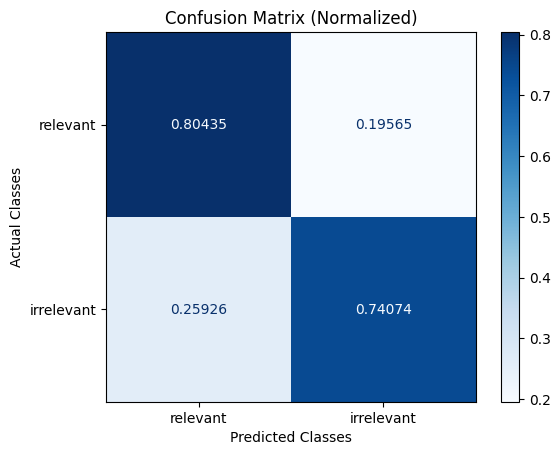

In [13]:
true_labels = df_sample["relevant"].map(RAG_RELEVANCY_PROMPT_RAILS_MAP).tolist()
relevance_classifications = (
    pd.Series(relevance_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for relevance, it can be useful to know why the LLM classified a document as relevant or irrelevant. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [21]:
small_df_sample = df_sample.copy().sample(n=5).reset_index(drop=True)
relevance_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE_STR,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
)

OpenAI invocation parameters: {'model': 'gpt-4', 'temperature': 0.0, 'max_tokens': 256, 'frequency_penalty': 0, 'presence_penalty': 0, 'top_p': 1, 'n': 1, 'timeout': None}


  0%|          | 0/5 [00:00<?, ?it/s]

- Snapped 'irrelevant' to rail: irrelevant
- Snapped 'irrelevant' to rail: irrelevant
- Snapped 'irrelevant' to rail: irrelevant
- Snapped 'relevant' to rail: relevant
- Snapped 'relevant' to rail: relevant


In [20]:
# Let's view the data
merged_df = pd.merge(small_df_sample, relevance_classifications_df, left_index=True, right_index=True)
merged_df[["query", "reference", "label", "explanation"]].head()

,query,reference,label,explanation
0,when was Bandaranaike Airport built,"Bandaranaike International Airport (BIA) (also known as Katunayake International Airport and Colombo International Airport) is one of the two international airports serving the city of Colombo , the other is Ratmalana International Airport . Mattala Rajapaksa International Airport located in southern city of Hambantota is the other international airport in Sri Lanka . Bandaranaike International Airport is located in Katunayake , 22 miles (35 km) north of Colombo . It is administered by Airport and Aviation Services (Sri Lanka) Ltd. It is the hub of SriLankan Airlines , the national carrier of Sri Lanka, and Mihin Lanka , the budget airline of Sri Lanka.",irrelevant,"The reference text provides information about the location, administration, and airlines of Bandaranaike International Airport, but it does not provide any information about when the airport was built."
1,when was scooby doo created,"Scooby-Doo is an American animated cartoon franchise , comprising several animated television series produced from 1969 to the present day. The original series, Scooby-Doo, Where Are You! , was created for Hanna-Barbera Productions by writers Joe Ruby and Ken Spears in 1969. This Saturday morning cartoon series featured four teenagers— Fred Jones , Daphne Blake , Velma Dinkley , and Norville ""Shaggy"" Rogers — and their talking brown Great Dane dog named Scooby-Doo , who solve mysteries involving supposedly supernatural creatures through a series of antics and missteps. Following the success of the original series, Hanna-Barbera and its successor Warner Bros. Animation have produced numerous follow-up and spin-off animated series and several related works, including television specials and telefilms, a line of direct-to-video films, and two Warner Bros. –produced theatrical feature films. Some versions of Scooby-Doo feature different variations on the show's supernatural theme, and include characters such as Scooby's cousin Scooby-Dum and nephew Scrappy-Doo in addition to or instead of some of the original characters. Scooby-Doo was originally broadcast on CBS from 1969 to 1976, when it moved to ABC . ABC aired the show until canceling it in 1986, and presented a spin-off featuring the characters as children, A Pup Named Scooby-Doo , from 1988 until 1991. Two new Scooby-Doo series, What's New, Scooby-Doo? and Shaggy and Scooby-Doo Get a a Clue!]], aired as part of Kids WB on The WB network and its successor, The CW network, from 2002 until 2008. The most recent Scooby-Doo series, Scooby-Doo! Mystery Incorporated , aired on Cartoon Network from 2010 to 2013. Repeats of the various Scooby-Doo series are broadcast frequently on Cartoon Network and Boomerang in the United States and other countries.",relevant,"The reference text mentions that Scooby-Doo was created in 1969, which directly answers the question."
2,what time is it in tampa florida,"Tampa () is a city in the U.S. state of Florida . It serves as the county seat for Hillsborough County and is located on the west coast of Florida, on Tampa Bay near the Gulf of Mexico . The population of Tampa in 2011 was 346,037. The current location of Tampa was once inhabited by indigenous peoples of the Safety Harbor culture , most notably the Tocobaga and the Pohoy , who lived along the shores of Tampa Bay . It was briefly explored by Spanish explorers in the early 16th century, but there were no permanent American or European settlements within today's city limits until after the United States had acquired Florida from Spain in 1819. In 1824, the United States Army established a frontier outpost called Fort Brooke at the mouth of the Hillsborough River , near the site of today's Tampa Convention Center . The first civilian residents were pioneers who settled near the fort for protection from the nearby Seminole population. The town grew slowly until the 1880s, when railroad links, the discovery of phosphate, and the 

## LLM Evals: relevance Classifications GPT-3.5
Run relevance against a subset of the data.

In [22]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, timeout=20)

In [23]:
rails = list(RAG_RELEVANCY_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df_sample, template=RAG_RELEVANCY_PROMPT_TEMPLATE_STR, model=model, rails=rails
)["label"]

  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    relevant       0.49      1.00      0.66        46
  irrelevant       1.00      0.11      0.20        54

    accuracy                           0.52       100
   macro avg       0.74      0.56      0.43       100
weighted avg       0.77      0.52      0.41       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

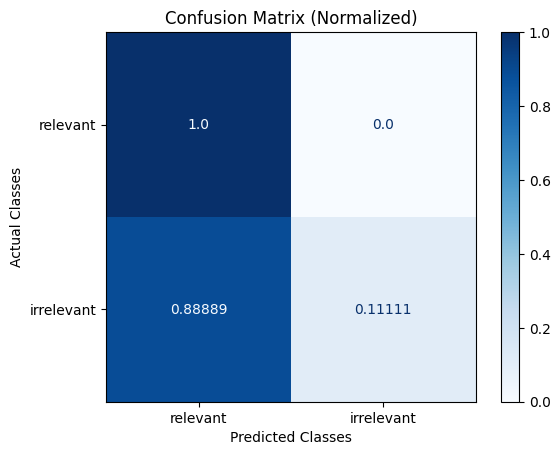

In [24]:
true_labels = df_sample["relevant"].map(RAG_RELEVANCY_PROMPT_RAILS_MAP).tolist()
relevance_classifications = (
    pd.Series(relevance_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)